In [198]:
import librosa
import numpy as np
import torch

def extract_pitch(file_path):
    y, sr = librosa.load(file_path, sr=None)  # librosa.load 함수에서 오디오 파일을 로드할 때 반환되는 값 
                                              # y = 오디오신호, sr = 샘플링 레이트(Sample Rate) -> 1초동안 들어온 오디오 샘플(즉, 오디오 품질)
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'), sr=sr)
    valid_f0 = f0[voiced_flag]  # 유효한 피치 데이터만 추출
    min_pitch = np.min(valid_f0) if np.any(valid_f0) else None
    max_pitch = np.max(valid_f0) if np.any(valid_f0) else None
    return min_pitch, max_pitch  # 최저음과 최고음 반환

In [199]:
# 샘플들(10개)의 파일 경로
file_paths = ["./data/IU/vocal/IU_1 [vocals].wav",
              "./data/IU/vocal/IU_2 [vocals].wav",
              "./data/IU/vocal/IU_3 [vocals].wav",
              "./data/IU/vocal/IU_4 [vocals].wav",
              "./data/IU/vocal/IU_5 [vocals].wav",
              "./data/IU/vocal/IU_6 [vocals].wav",
              "./data/IU/vocal/IU_7 [vocals].wav",
              "./data/IU/vocal/IU_8 [vocals].wav",
              "./data/IU/vocal/IU_9 [vocals].wav",
              "./data/IU/vocal/IU_10 [vocals].wav"]  

# 전체 노래 파일 경로 추가
full_song_path = "./data/IU/target/IU6 [vocals].wav"

In [200]:
# 샘플 및 전체 노래에 대한 피치 데이터 추출
all_pitches = []
for path in file_paths + [full_song_path]:
    min_pitch, max_pitch  = extract_pitch(path)
    all_pitches.append((min_pitch, max_pitch))
    print(f"File: {path} - Minimum pitch: {min_pitch}, Maximum pitch: {max_pitch}")

File: ./data/IU/vocal/IU_1 [vocals].wav - Minimum pitch: 65.40639132514966, Maximum pitch: 890.2251074656917
File: ./data/IU/vocal/IU_2 [vocals].wav - Minimum pitch: 128.565497341737, Maximum pitch: 633.1307752047607
File: ./data/IU/vocal/IU_3 [vocals].wav - Minimum pitch: 160.1218501126406, Maximum pitch: 554.3652619537442
File: ./data/IU/vocal/IU_4 [vocals].wav - Minimum pitch: 65.7852866955572, Maximum pitch: 954.1196458652481
File: ./data/IU/vocal/IU_5 [vocals].wav - Minimum pitch: 231.73942791006385, Maximum pitch: 885.097788139711
File: ./data/IU/vocal/IU_6 [vocals].wav - Minimum pitch: 184.9972113558172, Maximum pitch: 1843.2376561643027
File: ./data/IU/vocal/IU_7 [vocals].wav - Minimum pitch: 198.27510177438265, Maximum pitch: 564.0553960451207
File: ./data/IU/vocal/IU_8 [vocals].wav - Minimum pitch: 97.43442710125966, Maximum pitch: 739.9888454232688
File: ./data/IU/vocal/IU_9 [vocals].wav - Minimum pitch: 86.30425076864258, Maximum pitch: 731.4893486056533
File: ./data/IU/voc

In [201]:
# 샘플 데이터와 전체 노래 데이터 분리
sample_data = all_pitches[:-1]  # 샘플들의 데이터
full_song_data = all_pitches[-1]  # 전체 노래의 데이터

In [202]:
# Min-Max 정규화
min_pitch = min(p[0] for p in all_pitches if p[0] is not None)  
max_pitch = max(p[1] for p in all_pitches if p[1] is not None)
normalized_sample_data = [( (p[0]-min_pitch) / (max_pitch-min_pitch), (p[1]-min_pitch) / (max_pitch-min_pitch) ) for p in sample_data]
normalized_full_song_data = ((full_song_data[0]-min_pitch) / (max_pitch-min_pitch), (full_song_data[1]-min_pitch) / (max_pitch-min_pitch))

In [203]:
from sklearn.model_selection import train_test_split
# 데이터를 훈련 세트와 검증 세트로 분할
train_features, val_features, train_targets, val_targets = train_test_split(normalized_sample_data, 
                                                                            [normalized_full_song_data for _ in normalized_sample_data], 
                                                                            test_size=0.2, 
                                                                            random_state=42
)

In [204]:
from torch.utils.data import Dataset, DataLoader

class VocalRangeDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features  # 샘플의 피치 데이터
        self.targets = targets    # 전체 노래의 피치 데이터

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [205]:
# 데이터셋 생성
train_dataset = VocalRangeDataset(torch.tensor(train_features, dtype=torch.float32), torch.tensor(train_targets, dtype=torch.float32))
val_dataset = VocalRangeDataset(torch.tensor(val_features, dtype=torch.float32), torch.tensor(val_targets, dtype=torch.float32))

In [206]:
# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [220]:
import torch.nn as nn

class VocalRangeModel(nn.Module):
    def __init__(self):
        super(VocalRangeModel, self).__init__()
        self.lstm = nn.LSTM(input_size=2, hidden_size=50, num_layers=2, batch_first=True)
        self.fc = nn.Linear(50, 2)  # 최종 출력은 최저음과 최고음

    def forward(self, x):
        # LSTM 레이어
        out, (hidden, cell) = self.lstm(x)
        # 마지막 시간 단계의 출력을 사용
        out = self.fc(out[:, -1, :])
        return out

In [221]:
# 모델 인스턴스 생성
model = VocalRangeModel()

In [222]:
import torch.optim as optim
import matplotlib.pyplot as plt

# 손실 함수와 최적화 알고리즘 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# 손실을 저장할 리스트 초기화
train_losses = []
val_losses = []

# 학습 루프
EPOCHS = 50

for epoch in range(EPOCHS):  # 에포크 수 설정
    model.train()
    total_train_loss = 0
    num_batches = 0

    for data, targets in train_loader:
        optimizer.zero_grad()
        # 입력 데이터 차원 조정: 배치 크기 x 시퀀스 길이 x 특성 수
        outputs = model(data.unsqueeze(1))
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        num_batches += 1

    avg_train_loss = total_train_loss / num_batches
    train_losses.append(avg_train_loss)  # 훈련 손실 저장


    model.eval()
    val_loss = 0
    total_val_loss = 0
    num_val_batches = 0

    with torch.no_grad():
        for data, targets in val_loader:
            outputs = model(data.unsqueeze(1))
            val_loss += criterion(outputs, targets).item()
            total_val_loss += val_loss
            num_val_batches += 1

        avg_val_loss = total_val_loss / num_val_batches
        val_losses.append(avg_val_loss)  # 검증 손실 저장
    
    print(f'Epoch {epoch+1: >3},    Training Loss = {avg_train_loss:.8f},    Validation Loss = {avg_val_loss:.8f}')

Epoch   1,    Training Loss = 0.40951347,    Validation Loss = 0.40237087
Epoch   2,    Training Loss = 0.39991026,    Validation Loss = 0.39299661
Epoch   3,    Training Loss = 0.39053872,    Validation Loss = 0.38379154
Epoch   4,    Training Loss = 0.38126752,    Validation Loss = 0.37467936
Epoch   5,    Training Loss = 0.37210998,    Validation Loss = 0.36558262
Epoch   6,    Training Loss = 0.36292085,    Validation Loss = 0.35641736
Epoch   7,    Training Loss = 0.35362154,    Validation Loss = 0.34709978
Epoch   8,    Training Loss = 0.34415469,    Validation Loss = 0.33754927
Epoch   9,    Training Loss = 0.33442244,    Validation Loss = 0.32769334
Epoch  10,    Training Loss = 0.32431854,    Validation Loss = 0.31746846
Epoch  11,    Training Loss = 0.31382504,    Validation Loss = 0.30681521
Epoch  12,    Training Loss = 0.30295138,    Validation Loss = 0.29567444
Epoch  13,    Training Loss = 0.29141554,    Validation Loss = 0.28400975
Epoch  14,    Training Loss = 0.279417

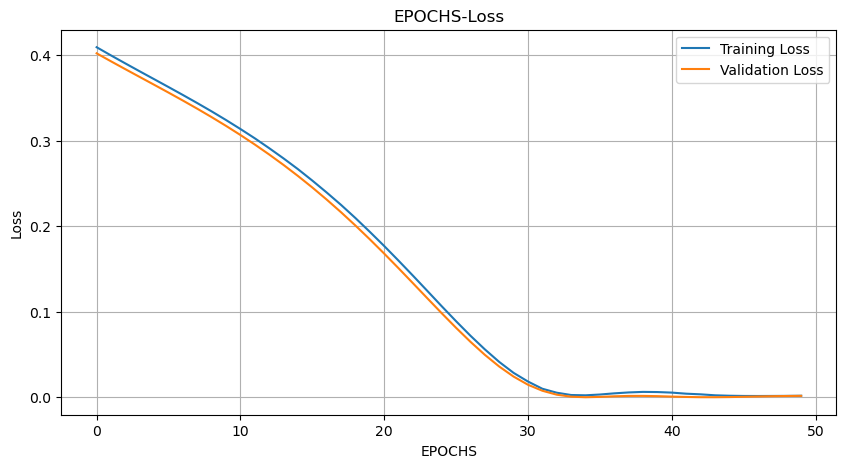

In [223]:
# 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('EPOCHS-Loss')
plt.xlabel('EPOCHS')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [224]:
def freq_to_note(freq):
    """ 주파수를 음악 노트로 변환 """
    if freq is not None and 20 <= freq <= 4000:  # 일반적인 인간의 음성 범위를 고려
        midi = librosa.hz_to_midi(freq)
        note = librosa.midi_to_note(midi, octave=True)
        return note
    else:
        return 'Out of range'  # 주파수 값이 유효하지 않은 경우

In [225]:
# 역스케일링 함수
def unscale_pitch(scaled_pitch, min_pitch, max_pitch):
    # min-max 스케일링한 값을 다시 역스케일링
    return scaled_pitch * (max_pitch - min_pitch) + min_pitch

# 예측 결과를 저장할 변수 초기화
final_predicted_min_freqs = []
final_predicted_max_freqs = []

# 학습 및 검증 루프
for epoch in range(EPOCHS):
    
    # 마지막 에포크에서 예측 결과 저장
    if epoch == EPOCHS - 1:
        with torch.no_grad():
            for data, targets in val_loader:
                outputs = model(data.unsqueeze(1))
                final_predicted_min_freqs.append(outputs[:, 0].mean().item())  # 최저음의 평균 주파수
                final_predicted_max_freqs.append(outputs[:, 1].mean().item())  # 최고음의 평균 주파수

# 평균 계산 및 역스케일링
final_min_freq = np.mean(final_predicted_min_freqs)
final_max_freq = np.mean(final_predicted_max_freqs)

# 역스케일링 적용
final_min_freq = unscale_pitch(final_min_freq, min_pitch, max_pitch)
final_max_freq = unscale_pitch(final_max_freq, min_pitch, max_pitch)

# 학습 완료 후 최종 예측된 음역대를 노트로 변환
final_min_note = freq_to_note(final_min_freq)
final_max_note = freq_to_note(final_max_freq)

# 최종 예측된 음역대 출력
print(f"Final Predicted Vocal Range: {final_min_note} to {final_max_note}")

Final Predicted Vocal Range: C♯2 to A6


In [226]:
# 음역대 비교 및 확률 계산 함수
def calculate_singing_probability(artist_range, song_range):
    artist_min_midi, artist_max_midi = librosa.note_to_midi([artist_range[0], artist_range[1]])
    song_min_midi, song_max_midi = librosa.note_to_midi([song_range[0], song_range[1]])
    overlap_min = max(artist_min_midi, song_min_midi)
    overlap_max = min(artist_max_midi, song_max_midi)
    overlap = max(0, overlap_max - overlap_min)
    song_range_length = song_max_midi - song_min_midi
    probability = overlap / song_range_length if song_range_length > 0 else 0
    return probability

In [227]:
# 다른 가수의 노래 파일 경로
other_artist_song_path = "./data/IU/target_song/check_in [vocals].wav"

In [228]:
# 다른 가수의 노래에서 음역대 추출
song_min_pitch, song_max_pitch = extract_pitch(other_artist_song_path)
song_min_note = librosa.hz_to_note(song_min_pitch)
song_max_note = librosa.hz_to_note(song_max_pitch)

In [216]:
# 최애 가수의 음역대
artist_min_note = 'C#2'  
artist_max_note = 'A6'  

In [217]:
# 부를 수 있는 확률 계산
probability = calculate_singing_probability((artist_min_note, artist_max_note), (song_min_note, song_max_note))
print(f"당신의 최애가 최애곡을 부를 수 있는 확률! : {probability:.2f}%")

당신의 최애가 최애곡을 부를 수 있는 확률! : 0.93%
